In [70]:
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime

# 3rd-part library for managing imbalanced data.
from imblearn.under_sampling import RandomUnderSampler
from IPython.core.interactiveshell import InteractiveShell
from tensorflow.keras.preprocessing.text import Tokenizer


In [71]:

%matplotlib inline

# Set dataframe options to keep long data in columns from being truncated with ellipsis (...)
pd.set_option('max_colwidth', None)

# Set dataframe options to force display max columns
pd.set_option('display.max_columns', 90)
pd.set_option('display.max_rows', 90)

InteractiveShell.ast_node_interactivity = "all"

random_state = 42


In [72]:

def create_dataframe(file_path):
    '''
    Create a pandas dataframe from a JSON file indicated by the parameter file_path
    '''
    data = []
    with open(file_path, encoding="utf8") as f:
        for jsonObj in f:
            data.append(json.loads(jsonObj))
    return pd.DataFrame(data)


def df_info(df):
    '''
    A helper function - similar in functionality with `df.info()` but includes combined features: df.columns, df.dtypes, 
    df.isnull(), df.info(), df.nunique()
    '''
    print('\nShape : {}'.format(df.shape))
    print('Number of duplicates : {}\n'.format(df.duplicated().sum()))

    print('{:^35} {:^12} {:^12} {:^8} {:>10}\n'.format('COLUMNS', 'DATA TYPE', 'HAS NULL', 'COUNTS', '# UNIQUE'))
    for i, v in enumerate(df.columns):
        col = df[v]
        dtype = type(col.iloc[0]).__name__
        
        if dtype=='dict':
            keys = set([item for val in col.values if val is not None for item in list(val.keys())])
            col_nunique = len(keys)
        else:
            col_nunique = col.nunique()
        
        print(' {:>2}.  {:<30} {:<12} {:^10} {:>8} {:>10}'.format(i+1, v, dtype, \
                                                                  str(col.isnull().any()), col.count(), \
                                                                  col_nunique))    # col.nunique()


In [73]:

review_json = '../yelp_dataset/yelp_academic_dataset_review.json'
review_df = create_dataframe(review_json)


In [74]:

df_info(review_df)



Shape : (8021122, 9)
Number of duplicates : 0

              COLUMNS                DATA TYPE     HAS NULL    COUNTS    # UNIQUE

  1.  review_id                      str            False     8021122    8021122
  2.  user_id                        str            False     8021122    1968703
  3.  business_id                    str            False     8021122     209393
  4.  stars                          float64        False     8021122          5
  5.  useful                         int64          False     8021122        266
  6.  funny                          int64          False     8021122        209
  7.  cool                           int64          False     8021122        200
  8.  text                           str            False     8021122    7999488
  9.  date                           str            False     8021122    7853102


Filter the dataframe to the features that are only needed.

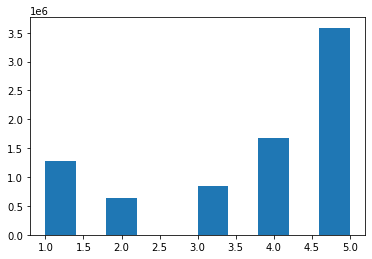

In [75]:

reviews_dataset = review_df.drop(['review_id', 'user_id', 'business_id', 'useful', 'funny', 'cool', 'date'], axis=1)
plt.hist(reviews_dataset.stars);

Patrons rate reviews from 1 through 5 with 5 being the highest.  The stars rating will be able to provide the appropriate label to the sentiments.

However in lieu of the star ratings, this can be collated into: `negative`, `neutral`, `positive`.  

Reviews with 1 and 2 will fall into the negative, 3 into neutral, 4 and 5 into positive.

In [76]:
category_labels = ['negative', 'neutral', 'positive']
cut_bins = [0, 2, 3, 5]
reviews_dataset['sentiment'] = pd.cut(reviews_dataset['stars'], bins=cut_bins, labels=category_labels)

Review the changes in the dataset; should now see the new column `sentiment`.

In [77]:
reviews_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8021122 entries, 0 to 8021121
Data columns (total 3 columns):
 #   Column     Dtype   
---  ------     -----   
 0   stars      float64 
 1   text       object  
 2   sentiment  category
dtypes: category(1), float64(1), object(1)
memory usage: 130.0+ MB


**Test the changes**.  All three queries should **not** return any values.

In [78]:
reviews_dataset.query('stars == 3 and (sentiment == "positive" or sentiment == "negative")')
reviews_dataset.query('stars < 3 and (sentiment == "neutral" or sentiment == "positive")')
reviews_dataset.query('stars > 3 and (sentiment == "negative" or sentiment == "neutral")')

,stars,text,sentiment


,stars,text,sentiment


,stars,text,sentiment


Persist the stripped-down dataset to make it more manageable and resource-utilization-friendly.

In [79]:

# Save the data to a new CSV file

reviews_dataset.to_csv('../yelp_dataset/reviews_dataset.csv', index=False)


Re-load the dataset.

In [81]:
reviews_dataset = pd.read_csv('../yelp_dataset/reviews_dataset.csv')

Divide the dataset into features and labels.

In [82]:
X = reviews_dataset[['text', 'stars']].values
y = reviews_dataset['sentiment'].values

The sentiment serves as a label to help in the process of training the model in the classification of reviews.
To effectively train the model with the dataset, we need to ensure the data has a balanced number of classifications.

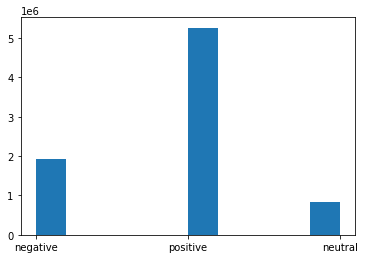

In [83]:
plt.hist(y);

> There is an imbalance in the dataset where there are significantly more `positive` rating than the other two sentiments.

To avoid bias where model is trained more on the positive labels, dataset need to be balanced.  A third-party library, `imb-learn` is used to under sample the dataset and balance out to the smallest denominator.

In [84]:

# RandomUnderSampler is used from the imblearn using the sampling-strategy auto
rus = RandomUnderSampler(sampling_strategy='auto', random_state=random_state)

# The result is a resampled dataset of X and y
X_res, y_res = rus.fit_resample(X, y)


Review the newly-balanced dataset.

In [85]:
X_res.shape[0]/X.shape[0]

0.3150266259508333

In [87]:
# sanity check, X and y should be equal in number of instances
np.shape(X_res), np.shape(y_res)

((2526867, 2), (2526867,))

> The balanced dataset has been reduced to 32% of its original size but with 2.53 million, it is still a substantial amount that can be used to train and test the model.

Review the distribution of the sentiments from the newly-balanced dataset.

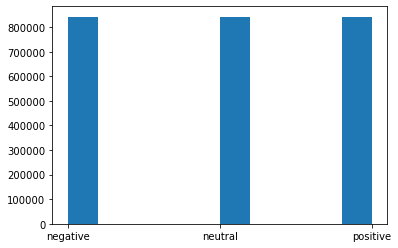

In [88]:
plt.hist(y_res);

> We now have a more balanced dataset across the different sentiments.